In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [89]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [5]:
!pip install pycaret

     |████████████████████████████████| 301 kB 21.5 MB/s            
     |████████████████████████████████| 15.6 MB 28.3 MB/s            
     |████████████████████████████████| 25.9 MB 24.9 MB/s            
     |████████████████████████████████| 114 kB 30.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 10.4 MB 15.0 MB/s            
     |████████████████████████████████| 167 kB 32.7 MB/s            
     |████████████████████████████████| 24.2 MB 48.1 MB/s            
     |████████████████████████████████| 636 kB 30.4 MB/s            
     |████████████████████████████████| 184 kB 33.2 MB/s            
     |████████████████████████████████| 1.0 MB 32.2 MB/s            
     |████████████████████████████████| 14.8 MB 16.8 MB/s            
     |████████████████████████████████| 79 kB 14.1 MB/s            
     |████████████████████████████████| 58 kB 10.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel fo

In [6]:
from pycaret.regression import *

In [7]:
#import modules
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [11]:
KAGGLE=False

In [12]:
if KAGGLE:
    path='../input/jobathonfebruary2022/'
else:
    path=''

In [166]:
train = pd.read_csv(path+'train_0OECtn8.csv')
test = pd.read_csv(path+'test_1zqHu22.csv')
subm = pd.read_csv(path+'sample_submission_JPlpRcN.csv')

In [167]:
print(train.shape)
print(test.shape)

(89197, 10)
(11121, 9)


In [168]:
# def ordinal_dummy_coding(data,cols):
#     data_updated = data.copy()
#     for col in cols:
#         enc_unique = np.sort(data[col].unique())
#         start_enc = enc_unique[0]
#         data_updated = pd.get_dummies(data_updated,columns = [col], prefix=[col])
#         print('after_dummy_update:',data_updated.columns)
#         print('after_dummy_update:',data_updated.head())
#         for enc_val in enc_unique:
#             #remove 1st dummy variable since it will become constant value
#             #as all higher values of 1 will always update it to 1

#             dummy_col = col+'_'+str(enc_val)
#             if enc_val==start_enc:
#                 del data_updated[dummy_col]
#                 continue
                
#             mask = data_updated[dummy_col]==1
#             for prior_enc in range(start_enc+1,enc_val):
#                 prior_dummy_col = col+'_'+str(prior_enc)
#                 data_updated[prior_dummy_col][mask] = 1
            
#     return data_updated    

In [169]:
# print(np.sort(train['followers'].unique()))
# print(np.sort(test['followers'].unique()))

In [170]:
# keys = np.sort(train['followers'].unique())
# values = range(train['followers'].nunique())
# followers_map = dict(zip(keys, values))
# print(followers_map) 

In [171]:
# train['istrain']=1
# test['istrain']=0

# combined = pd.concat([train,test],axis=0)

In [172]:
# combined['followers'] = combined['followers'].replace(followers_map)
# combined= ordinal_dummy_coding(combined,['followers'])

In [173]:
# train= combined[combined['istrain']==1]
# test= combined[combined['istrain']==0]

# del combined,train['istrain'],test['istrain']

In [174]:
print(train.columns)
print(test.columns)

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score'],
      dtype='object')
Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views'],
      dtype='object')


In [175]:
def preproc(train,test):
    label_encoder = LabelEncoder()

    train['gender']= label_encoder.fit_transform(train['gender'])
    test['gender']= label_encoder.transform(test['gender'])
    
    #ordinal encoding of profession
    prof_map = {'Other':0,'Student':1,'Working Professional':2}
    train['profession'] = train['profession'].map(prof_map)
    test['profession'] = test['profession'].map(prof_map)
    
    #to have video id without target encoding
    train['video_id_raw']=train['video_id'].copy()
    
def gen_agg(train,test):
    #user_id aggregate features
    user_agg = train[['user_id','video_id','category_id']].groupby('user_id').agg('nunique').reset_index()
    user_agg = user_agg.rename({'video_id':'user_video_count','category_id':'user_category_count'},axis=1)
    train = pd.merge(train, user_agg, how='left', on='user_id')
    test = pd.merge(test, user_agg, how='left', on='user_id')
    
    
    #category_id aggregate features
    cat_agg = train[['category_id','user_id','video_id','age','gender','profession']] \
                        .groupby('category_id') \
                        .agg({'user_id':'nunique','video_id':'nunique', \
                             'age':'mean','gender':'mean','profession':'mean'}) \
                        .reset_index()
    cat_agg = cat_agg.rename({'user_id':'category_user_count',
                              'video_id':'category_video_count',
                              'age':'category_age_mean',
                              'gender':'category_gender_mean',
                              'profession':'category_profession_mean',
                             }, axis=1)
    train = pd.merge(train, cat_agg, how='left', on='category_id')
    test = pd.merge(test, cat_agg, how='left', on='category_id')    
    
    #video_id aggregate features
    video_agg = train[['video_id','age','gender','profession']] \
                        .groupby('video_id') \
                        .agg('mean') \
                        .reset_index() 
    video_agg = video_agg.rename({'age':'video_age_mean',
                              'gender':'video_gender_mean',
                              'profession':'video_profession_mean',
                             },axis=1)
    train = pd.merge(train, video_agg, how='left', on='video_id')
    test = pd.merge(test, video_agg, how='left', on='video_id')
    
    return train,test
        

In [176]:
preproc(train,test)

In [177]:
train,test = gen_agg(train,test)

In [178]:
print(train.columns)
train.head()

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score', 'video_id_raw',
       'user_video_count', 'user_category_count', 'category_user_count',
       'category_video_count', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean', 'video_age_mean', 'video_gender_mean',
       'video_profession_mean'],
      dtype='object')


,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,...,user_video_count,user_category_count,category_user_count,category_video_count,category_age_mean,category_gender_mean,category_profession_mean,video_age_mean,video_gender_mean,video_profession_mean
0,1,19990,37,128,24,1,1,180,1000,4.33,...,3,2,635,2,24.816008,0.602911,0.922037,24.864811,0.602386,0.912525
1,2,5304,32,132,14,0,1,330,714,1.79,...,5,3,1507,4,24.884218,0.563053,0.862832,25.104735,0.569584,0.892396
2,3,1840,12,24,19,1,1,180,138,4.35,...,3,1,2020,6,24.836205,0.670352,0.883775,25.039640,0.681081,0.935135
3,4,12597,23,112,19,1,1,220,613,3.77,...,3,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044
4,5,13626,23,112,27,1,2,220,613,3.13,...,4,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044


In [179]:
targetcol = 'engagement_score'
target = train[targetcol]

In [180]:
exclude_cols =['row_id', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean',  'video_gender_mean',
       'video_profession_mean','video_id_raw',
            'video_age_mean',
        'video_age_ratio', 'video_profession_diff', 
        'video_profession_ratio', 'video_gender_diff', 'video_gender_ratio']
features =[col for col in train.columns if col not in exclude_cols]
print(len(features))
print(features)
features_excl_target = [col for col in features if col!=targetcol]

13
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'engagement_score', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count']


In [181]:
catcols = []
numeric_cols = [col for col in features if col not in catcols+[targetcol]]
print(len(catcols))
print(catcols)
print(len(numeric_cols))
print(numeric_cols)

0
[]
12
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count']


In [183]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [184]:
# preprocessor = ('Target encoding', TargetEncoder(cols=['user_id','category_id', 'video_id','followers'],
#                                                 min_samples_leaf=2, smoothing=0.1) )

ct = ColumnTransformer(
     [
     ("targetenc",  LeaveOneOutEncoder() , ['user_id','category_id', 'video_id']),
#          ("targetenc",  TargetEncoder(cols=['user_id','category_id', 'video_id'],
#                                                 min_samples_leaf=2, smoothing=0.1) , ['user_id','category_id', 'video_id']),
#     ("targetenc2",  TargetEncoder(cols=['followers'],
#                                                     min_samples_leaf=2, smoothing=0.1) , ['followers']),
#       ("rank",  FunctionTransformer(lambda x: x*10000) , ['followers']),
      ],remainder='passthrough')

# ct2 = ColumnTransformer(
#      [("rank",  FunctionTransformer(lambda x: x.rank()) , ['followers'])
#       ],remainder='passthrough')
preprocessor = ('preproc',ct)

In [185]:
# ct.fit(train,target)
# temp = ct.transform(train)
# temp[0:10,:]

In [186]:
# ce_target=TargetEncoder(cols=['user_id','category_id', 'video_id'],
#                        min_samples_leaf=2, smoothing=0.1)
# ce_target.fit(train,target)

# ret =ce_target.transform(train,target)
# ret.head()

In [187]:
s = setup(train[features], session_id=100,
          silent=True,
          numeric_features=numeric_cols,
          categorical_features=catcols,
          target = targetcol,
          custom_pipeline=preprocessor,
          fold=10,fold_shuffle=False,
          )

,Description,Value
0,session_id,100
1,Target,engagement_score
2,Original Data,"(89197, 13)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(62437, 12)"


In [188]:
X= get_config('X')
print(len(X.columns))
print(list(X.columns))
X.head()

12
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count']


,user_id,category_id,video_id,age,gender,profession,followers,views,user_video_count,user_category_count,category_user_count,category_video_count
0,19990.0,37.0,128.0,24.0,1.0,1.0,180.0,1000.0,3.0,2.0,635.0,2.0
1,5304.0,32.0,132.0,14.0,0.0,1.0,330.0,714.0,5.0,3.0,1507.0,4.0
2,1840.0,12.0,24.0,19.0,1.0,1.0,180.0,138.0,3.0,1.0,2020.0,6.0
3,12597.0,23.0,112.0,19.0,1.0,1.0,220.0,613.0,3.0,2.0,1705.0,2.0
4,13626.0,23.0,112.0,27.0,1.0,2.0,220.0,613.0,4.0,2.0,1705.0,2.0


In [189]:
%%time
lgbm = create_model('lightgbm')
lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5166,0.4852,0.6965,0.3777,0.1964,0.2448
1,0.5155,0.4676,0.6838,0.3661,0.1857,0.2429
2,0.5309,0.5028,0.7091,0.3479,0.1955,0.2930
3,0.5128,0.4668,0.6833,0.3678,0.1863,0.2247
4,0.5193,0.4760,0.6899,0.3723,0.1896,0.2040
5,0.5213,0.4813,0.6938,0.3545,0.1880,0.2305
6,0.5116,0.4617,0.6795,0.3677,0.1828,0.1975
7,0.5257,0.4853,0.6966,0.3551,0.1902,0.2409
8,0.5080,0.4503,0.6711,0.3779,0.1804,0.2428
9,0.5180,0.4697,0.6853,0.3786,0.1884,0.2638


CPU times: user 3.43 s, sys: 26.2 ms, total: 3.45 s
Wall time: 2.3 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

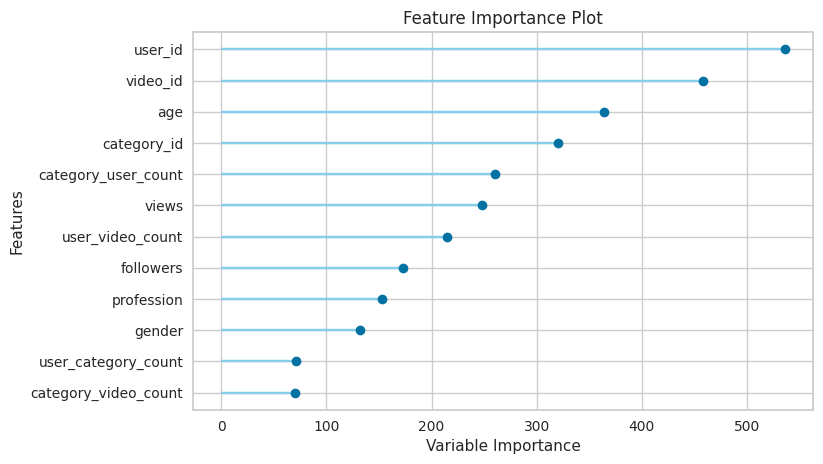

In [190]:
plot_model(lgbm,'feature_all')

In [191]:
%%time
#test predictions
final_model = finalize_model(lgbm)
test_preds = predict_model(final_model, data=test)
print(test_preds.head())

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0   89198     7986           12        42   14       1           1        180   
1   89199    11278           34       115   14       1           1        230   
2   89200    17245            8       110   44       0           2        280   
3   89201     9851           16       137   18       1           1        270   
4   89202    16008           34        96   47       0           0        230   

   views  user_video_count  user_category_count  category_user_count  \
0    138                 2                    1                 2020   
1    840                 5                    3                 1679   
2    628                 5                    2                 3043   
3    462                 3                    2                 1670   
4    840                 3                    2                 1679   

   category_video_count  category_age_mean  category_gender_mean  \
0           

In [192]:
%%time
#train predictions
train_preds = predict_model(final_model, data=train)
print(train_preds.head())
print('full train score:',r2_score(target,train_preds['Label']))

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0       1    19990           37       128   24       1           1        180   
1       2     5304           32       132   14       0           1        330   
2       3     1840           12        24   19       1           1        180   
3       4    12597           23       112   19       1           1        220   
4       5    13626           23       112   27       1           2        220   

   views  engagement_score  ...  user_category_count  category_user_count  \
0   1000              4.33  ...                    2                  635   
1    714              1.79  ...                    3                 1507   
2    138              4.35  ...                    1                 2020   
3    613              3.77  ...                    2                 1705   
4    613              3.13  ...                    2                 1705   

   category_video_count  category_age_mean  catego

In [193]:
lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

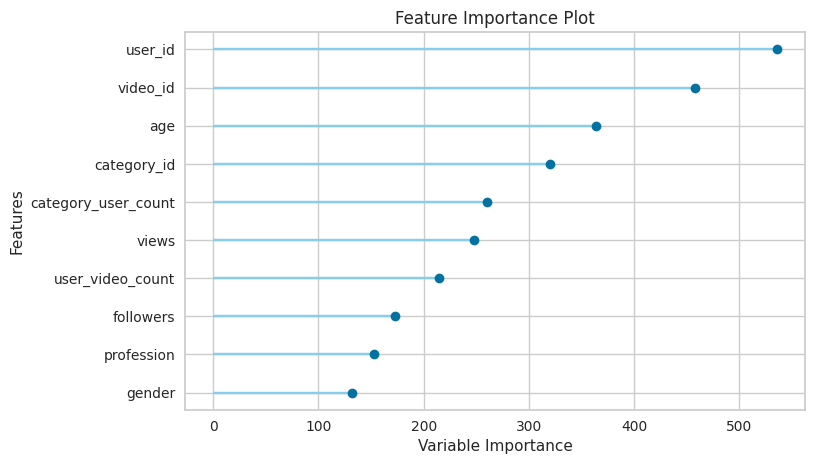

In [194]:
plot_model(lgbm,'feature')

In [195]:
submission = test_preds[['row_id','Label']]
submission=submission.rename(columns={'Label':'engagement_score'})
submission[['row_id','engagement_score']].to_csv('submission.csv',index=False)

In [196]:
test_sub = pd.read_csv('submission.csv')

In [197]:
print(test_sub.shape)
test_sub.head()

(11121, 2)


,row_id,engagement_score
0,89198,4.110569
1,89199,3.655346
2,89200,2.834526
3,89201,3.800316
4,89202,2.401588
